In [1]:
import pandas as pd
from statsmodels.stats.contingency_tables import cochrans_q, mcnemar
import statsmodels.stats
import scipy.stats
import numpy as np
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import matplotlib

In [2]:
THRESHOLD = 0.05 #alpha significance level
PREDICTIONS_DIR = 'predictions'

tasks = {
    'binary': [0, 1], 
    'strat-binary': [0, 1],
    '4type': [0, 1, 2, 3],
    '5type': [0, 1, 2, 3, 4],
}
representations = ['bow', 'freq', 'tfidf']
models = ['decision-tree', 'svm', 'naive-bayes', 'xgboost']
methods = ['RandomUnder', 'SMOTETomek', 'RandomOver', 'ADASYN', 'none', 'aug']

In [3]:
#find the mode of a numpy array
def mode(array):
    freq = np.bincount(array)
    return np.argmax(freq)

In [4]:
def shorten_name(name):
    shortenings = {
    'decision-tree': 'dt',
    'naive-bayes-multinomial': 'nbm',
    'naive-bayes': 'nb',
    'xgboost': 'xgb',
    '-classification': '',
    '-type_of_antisemitism': '',}
    for long_version in shortenings:
        name = name.replace(long_version, shortenings[long_version])
    return name

#visualize the results of a post-hoc dunn analysis on a cochran's q test using matplotlib in a matrix
def visualize_dunn(dunn_values, names):
    names = [shorten_name(name) for name in names]
    
    plt.matshow(dunn_values)
    ax = plt.gca()
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_xticklabels(labels=names,rotation=90)
    ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_yticklabels(labels=names)
    
    #pulled these next two lines from stack overflow, just to display the values
    for (i, j), z in np.ndenumerate(dunn_values):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
        
    plt.pause(0.1)

In [5]:
#find the raw accuracy scores of all of the columns
def find_accuracy(df):
    accuracies = [1,]
    for column in [column for column in df.columns.values if column != 'Actual']:
        df[column] = df.apply(lambda x: int(x[column] == x['Actual']), axis=1)
        accuracies.append(df[column].mean())
    return accuracies

In [6]:
#combine columns in a dataframe whose names contain certain substrings
def combine_columns(df, substrings):
    '''
    df: the input dataframe that has many column names that contain certain common substrings
    substrings: the list of substrings used for combination
    
    returns: `output_df`, a DataFrame with `substrings` as its columns. Each row is the mode
    of the value for that row of all of the columns in `df` that contained that substring.
    '''
    output_df = pd.DataFrame()
    
    for column_substring in substrings:
        temp_df = pd.DataFrame()
        to_be_combined = [column for column in df.columns.values if column_substring in column]
        
        for column in to_be_combined:
            temp_df[column] = df[column]
            
        array = np.array(temp_df).astype(int)
        array = [mode(row) for row in array]
            
        output_df[column_substring] = array
    
    return output_df

In [7]:
#find which models performed best using basic accuracy score
def evaluate_models(df, substrings):
    output_df = pd.DataFrame()
    temp_df = combine_columns(df, substrings)
    for column in substrings:
        temp_df[column] = temp_df[column] == df['Actual']
        output_df[column] = [sum(temp_df[column])/len(temp_df),]
    output_df.index = ['Score']
    if 'index' in output_df.columns.values: del output_df['index']
    return output_df

#test model significance difference w/ Friedman Chi^2 while combining certain columns
def test_model_difference(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    cochran_result = cochrans_q(columns)
    return cochran_result

def post_hoc_tests(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    p_values = sp.posthoc_dunn(columns)
    return p_values

In [8]:
#get a list of binary dfs of whether or not they fit with a particular classification
def get_dfs(df, classifications):
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    return dfs

#find specific rankings for each model
def overall_evaluation(task, classifications, method):
    df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
    score_df = pd.DataFrame()
    dfs = get_dfs(df, classifications)
        
    for (i, temp_df) in enumerate(dfs):
        temp_df = evaluate_models(temp_df, temp_df.columns.values).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
            
        score_df[f'Score {i}'] = temp_df['Score']
    
    score_df['Mean score'] = score_df.mean(axis=1)
    score_df['Accuracy'] = find_accuracy(df)
    score_df = score_df.sort_values('Mean score', ascending = False)
    cochran_result = cochrans_q(df)
    post_hoc_p = pd.DataFrame()
    if cochran_result.pvalue <= THRESHOLD:
        post_hoc_p = post_hoc_tests(df, df.columns.values)
    
    print(f'Task: {task}.')
    print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
    if cochran_result.pvalue <= THRESHOLD:
        print('Post-hoc Dunn test array:')
        visualize_dunn(post_hoc_p, df.columns.values)
    
    score_df.index = [shorten_name(name) for name in score_df.index]
    print(score_df)
    print(f'\nMean: {score_df["Mean score"].mean()}')
    print('\n\n')
    return score_df

In [9]:
def evaluate_rep_model(grouping, dfs):
    final_df = pd.DataFrame()
    
    for i, df in enumerate(dfs):
        temp_df = evaluate_models(df, grouping).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
        
        temp_df.columns = ['Score']
        final_df[f'Score {i}'] = temp_df['Score']
        
    return final_df

#evaluate algorithms and representations, find significance level
def algorithm_and_rep_eval(task, classifications, method):
    df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    for grouping in [representations, models]:
        score_df = evaluate_rep_model(grouping, dfs)
        score_df['Mean score'] = score_df.mean(axis=1)
        score_df = score_df.sort_values('Mean score', ascending = False)
        
        combined_df = combine_columns(df, grouping)
        cochran_result = cochrans_q(combined_df)
        if cochran_result.pvalue <= THRESHOLD:
            post_hoc_p = post_hoc_tests(combined_df, grouping)
        
        print(f'Task: {task}. Grouping: {grouping}.')
        print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
        if cochran_result.pvalue <= THRESHOLD:
            print('Post-hoc Dunn test array:')
            visualize_dunn(post_hoc_p, grouping)
        
        score_df.index = [shorten_name(name) for name in score_df.index]
        print(f"Scores: \n{score_df}")
        print(f'\nMean: {score_df["Mean score"].mean()}')
        print('\n\n')

In [10]:
#evaluate the overall resampling methods, perform friedman test and post-hoc nemenyi
def evaluate_resampling(overall_df, indeces):
    columns = [overall_df[column] for column in overall_df.columns.values]
    statistic, pvalue = scipy.stats.friedmanchisquare(*columns)
    overall_df.loc[len(overall_df)] = overall_df.apply(lambda x: np.mean(x))
    indeces.append('Mean')
    overall_df.index = indeces
    print('\nOverall scores:')
    print(f'Friedman Chi Square Statistic: {statistic}. p-value: {pvalue}.')
    print(overall_df)
    if pvalue <= THRESHOLD:
        overall_df = overall_df.transpose()
        columns = [overall_df[column] for column in overall_df.columns.values]
        p_values = sp.posthoc_nemenyi_friedman(columns)
        print('\nPost-hoc Dunn test array:')
        visualize_dunn(p_values, list(overall_df.index))

The below visualizations and `DataFrame`s contain testing information on the various algorithms and representation methods used to create models. Data is shown on two tasks, 'binary,' referring to the binary classification of whether or not a particular tweet is antisemitic, and 'type,' referring to classifying the tweet with a particular type of antisemitism. The model evaluation was done in two stages, first the overall evaluation, then the grouped evaluation for different algorithms and representations. Some names are shortened during presentation: `decision-tree` is shortened to `dt`, `naive-bayes-multinomial` to `nbm`, and `naive-bayes` to `nb`.

For the overall evaluation, the model scores were generated using the arithmetic mean of the recalls on each individual class, with a Cochran's Q test being performed on a matrix that contained columns for each model and in each column contained a `1` where the model found the correct answer, and `0` where the model found the incorrect answer. Then, if the Q test found an *p*-value lower than the specified global `THRESHOLD` constant, it performs a post-hoc Dunn text, which is then visualized in the form of a matrix, with higher values meaning lighter colors and a greater correlation between two models' answers. Then, the score `DataFrame` is shown, with a column entitled `Mean score` for the arithmetic mean of the recall of the model on each class. There are additional columns entitles `Score {x}`, with `{x}` being the specific class that that column gives the recall of for each model. Finally, an overall mean of the `Mean score` column is given.

For the model grouping evaluation, models are grouped into classes either by their representation or algorithm type. The most common answer across all models of this type is then taken as the answer for this grouping. Following this, the same process as above was used.

In [11]:
def task_eval(task):
    print(f'\nTask: {task.title()}\n')
    overall_df = pd.DataFrame()
    indeces = []
    for method in methods:
        print(f'\nMethod: {method}\n')
        temp_df = overall_evaluation(task, tasks[task], method) #find the rankings for all models
        if not indeces:
            indeces = list(temp_df.index)
        overall_df[method] = temp_df['Mean score']
        #algorithm_and_rep_eval(task, tasks[task], method) #group representations and algorithms together, evaluate
    evaluate_resampling(overall_df, indeces)


Task: Binary


Method: RandomUnder

Task: binary.
Cochran's Q test p-value: 4.269357342626575e-250
Post-hoc Dunn test array:


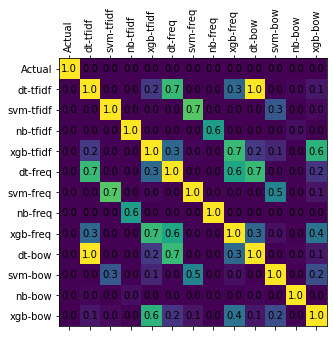

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.737443  0.625000    0.681221  0.558197
xgb-bow    0.702055  0.633721    0.667888  0.673770
svm-freq   0.799087  0.520349    0.659718  0.727049
svm-tfidf  0.819635  0.491279    0.655457  0.646721
xgb-tfidf  0.700913  0.604651    0.652782  0.654918
xgb-freq   0.688356  0.607558    0.647957  0.720492
dt-freq    0.687215  0.572674    0.629945  0.546721
dt-tfidf   0.681507  0.558140    0.619823  0.665574
dt-bow     0.681507  0.558140    0.619823  0.646721
nb-bow     0.585616  0.633721    0.609669  0.705738
nb-tfidf   0.501142  0.703488    0.602315  0.682787
nb-freq    0.504566  0.654070    0.579318  0.599180

Mean: 0.6635319920601858




Method: SMOTETomek

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


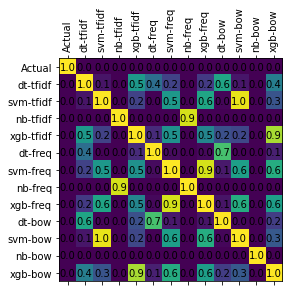

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.804795  0.534884    0.669839  0.425410
svm-tfidf  0.810502  0.523256    0.666879  0.729508
xgb-bow    0.770548  0.546512    0.658530  0.718852
svm-freq   0.799087  0.508721    0.653904  0.717213
xgb-freq   0.811644  0.482558    0.647101  0.691803
dt-bow     0.736301  0.540698    0.638500  0.681148
xgb-tfidf  0.800228  0.459302    0.629765  0.673770
dt-tfidf   0.802511  0.409884    0.606198  0.704098
dt-freq    0.781963  0.398256    0.590110  0.423770
nb-bow     0.463470  0.622093    0.542782  0.728689
nb-tfidf   0.278539  0.799419    0.538979  0.508197
nb-freq    0.277397  0.796512    0.536954  0.707377

Mean: 0.6445799740240645




Method: RandomOver

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


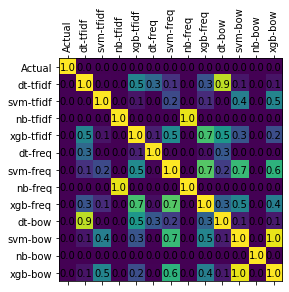

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.777397  0.575581    0.676489  0.446721
xgb-bow    0.787671  0.552326    0.669998  0.664754
svm-tfidf  0.833333  0.488372    0.660853  0.683607
svm-freq   0.789954  0.514535    0.652245  0.698361
xgb-freq   0.791096  0.488372    0.639734  0.445902
dt-bow     0.750000  0.523256    0.636628  0.686066
xgb-tfidf  0.778539  0.494186    0.636362  0.712295
nb-bow     0.582192  0.668605    0.625398  0.720492
dt-tfidf   0.800228  0.386628    0.593428  0.736066
dt-freq    0.763699  0.412791    0.588245  0.705738
nb-freq    0.305936  0.805233    0.555584  0.721311
nb-tfidf   0.315068  0.779070    0.547069  0.606557

Mean: 0.6524641401393552




Method: ADASYN

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


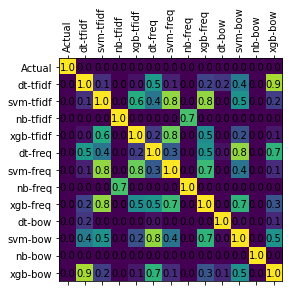

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-freq   0.748858  0.575581    0.662220  0.678689
svm-tfidf  0.743151  0.575581    0.659366  0.700000
svm-bow    0.713470  0.604651    0.659061  0.406557
xgb-bow    0.697489  0.598837    0.648163  0.691803
xgb-freq   0.757991  0.523256    0.640623  0.705738
xgb-tfidf  0.797945  0.470930    0.634438  0.666393
dt-bow     0.654110  0.598837    0.626473  0.638525
dt-freq    0.788813  0.398256    0.593534  0.695902
dt-tfidf   0.770548  0.401163    0.585855  0.413934
nb-bow     0.447489  0.636628    0.542058  0.682787
nb-tfidf   0.268265  0.784884    0.526574  0.500820
nb-freq    0.259132  0.781977    0.520555  0.669672

Mean: 0.6383785257431323




Method: none

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


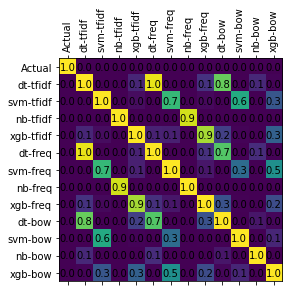

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.918950  0.415698    0.667324  0.474590
xgb-bow    0.871005  0.427326    0.649165  0.726230
nb-bow     0.704338  0.563953    0.634146  0.777049
svm-tfidf  0.940639  0.325581    0.633110  0.767213
xgb-tfidf  0.864155  0.375000    0.619578  0.694262
dt-bow     0.811644  0.418605    0.615124  0.700820
xgb-freq   0.864155  0.363372    0.613764  0.759016
svm-freq   0.949772  0.273256    0.611514  0.695082
dt-freq    0.820776  0.372093    0.596435  0.722951
dt-tfidf   0.826484  0.360465    0.593475  0.472951
nb-tfidf   0.361872  0.761628    0.561750  0.664754
nb-freq    0.359589  0.761628    0.560608  0.745902

Mean: 0.6427686017921762




Method: aug

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


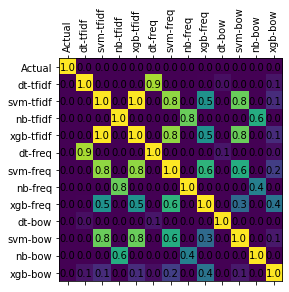

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.788813  0.572674    0.680744  0.722131
xgb-bow    0.724886  0.607558    0.666222  0.718033
svm-tfidf  0.807078  0.505814    0.656446  0.459016
xgb-tfidf  0.808219  0.502907    0.655563  0.722131
xgb-freq   0.781963  0.523256    0.652610  0.650820
svm-freq   0.820776  0.456395    0.638586  0.654098
dt-freq    0.704338  0.514535    0.609436  0.709016
dt-tfidf   0.720320  0.485465    0.602892  0.453279
dt-bow     0.649543  0.523256    0.586400  0.613934
nb-tfidf   0.307078  0.845930    0.576504  0.468852
nb-freq    0.302511  0.837209    0.569860  0.691803
nb-bow     0.343607  0.787791    0.565699  0.727869

Mean: 0.650843196837144




Overall scores:
Friedman Chi Square Statistic: 15.000000000000023. p-value: 0.010362337915786345.
           RandomUnder  SMOTETomek  RandomOver    ADASYN      none       aug
Actual        1.000000    1.000000    1.000000  1.000000  1.000000  

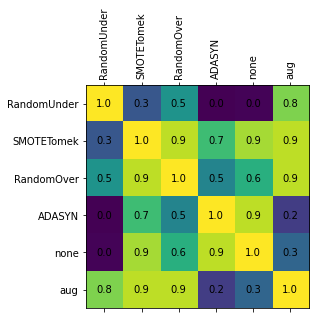

In [12]:
task_eval('binary')


Task: Strat-Binary


Method: RandomUnder

Task: strat-binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


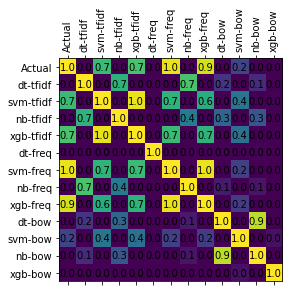

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
dt-tfidf   0.565068  0.639535    0.602302  0.289344
dt-bow     0.509132  0.680233    0.594682  0.504098
nb-freq    0.609589  0.552326    0.580957  0.290164
dt-freq    0.446347  0.651163    0.548755  0.281148
nb-tfidf   0.628995  0.444767    0.536881  0.586066
nb-bow     0.581050  0.488372    0.534711  0.577049
xgb-bow    0.119863  0.927326    0.523594  0.593443
svm-bow    0.043379  0.979651    0.511515  0.280328
svm-tfidf  0.014840  0.991279    0.503060  0.307377
xgb-tfidf  0.017123  0.982558    0.499841  0.557377
svm-freq   0.000000  0.997093    0.498547  0.347541
xgb-freq   0.002283  0.988372    0.495328  0.554918

Mean: 0.5715517558262063




Method: SMOTETomek

Task: strat-binary.
Cochran's Q test p-value: 8.087798241466266e-172
Post-hoc Dunn test array:


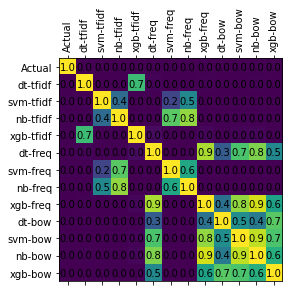

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
xgb-tfidf  0.744292  0.313953    0.529123  0.419672
dt-tfidf   0.770548  0.276163    0.523355  0.631148
svm-tfidf  0.291096  0.747093    0.519094  0.563934
svm-freq   0.357306  0.668605    0.512955  0.557377
xgb-freq   0.660959  0.357558    0.509259  0.445082
nb-tfidf   0.351598  0.659884    0.505741  0.571311
xgb-bow    0.640411  0.369186    0.504799  0.434426
dt-bow     0.627854  0.377907    0.502880  0.575410
nb-bow     0.665525  0.340116    0.502821  0.578689
nb-freq    0.351598  0.645349    0.498474  0.573770
svm-bow    0.668950  0.322674    0.495812  0.622951
dt-freq    0.691781  0.290698    0.491239  0.438525

Mean: 0.5458116867204156




Method: RandomOver

Task: strat-binary.
Cochran's Q test p-value: 4.4039975200201246e-197
Post-hoc Dunn test array:


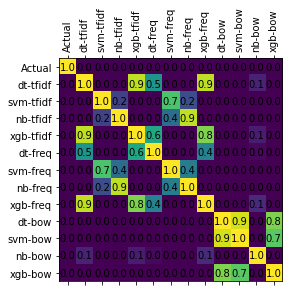

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.718037  0.447674    0.582855  0.427869
xgb-bow    0.726027  0.404070    0.565049  0.401639
dt-bow     0.739726  0.386628    0.563177  0.522131
svm-tfidf  0.243151  0.805233    0.524192  0.635246
nb-bow     0.448630  0.590116    0.519373  0.519672
nb-tfidf   0.317352  0.709302    0.513327  0.640164
nb-freq    0.313927  0.709302    0.511615  0.641803
svm-freq   0.277397  0.744186    0.510792  0.488525
xgb-tfidf  0.573059  0.401163    0.487111  0.409016
xgb-freq   0.563927  0.406977    0.485452  0.425410
dt-freq    0.619863  0.319767    0.469815  0.524590
dt-tfidf   0.607306  0.305233    0.456269  0.535246

Mean: 0.5530020380490276




Method: ADASYN

Task: strat-binary.
Cochran's Q test p-value: 1.4749268642038663e-295
Post-hoc Dunn test array:


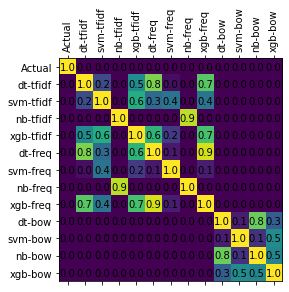

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-freq   0.916667  0.267442    0.592054  0.458197
svm-tfidf  0.907534  0.229651    0.568593  0.706557
dt-freq    0.905251  0.168605    0.536928  0.697541
dt-tfidf   0.899543  0.165698    0.532621  0.733607
xgb-tfidf  0.936073  0.122093    0.529083  0.692623
xgb-freq   0.932648  0.104651    0.518650  0.716393
nb-freq    0.413242  0.581395    0.497319  0.598361
nb-bow     0.731735  0.258721    0.495228  0.627049
nb-tfidf   0.412100  0.575581    0.493841  0.613115
xgb-bow    0.788813  0.165698    0.477255  0.699180
dt-bow     0.743151  0.209302    0.476227  0.592623
svm-bow    0.824201  0.125000    0.474600  0.460656

Mean: 0.5532613889773814




Method: none

Task: strat-binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


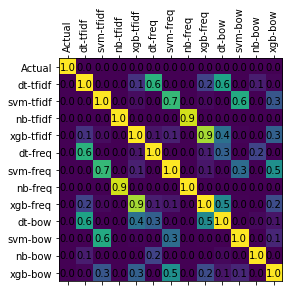

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.918950  0.415698    0.667324  0.474590
xgb-bow    0.871005  0.427326    0.649165  0.726230
nb-bow     0.704338  0.563953    0.634146  0.777049
svm-tfidf  0.940639  0.325581    0.633110  0.767213
dt-bow     0.816210  0.436047    0.626128  0.709016
xgb-tfidf  0.864155  0.375000    0.619578  0.689344
xgb-freq   0.864155  0.363372    0.613764  0.759016
svm-freq   0.949772  0.273256    0.611514  0.698361
dt-tfidf   0.824201  0.377907    0.601054  0.472951
dt-freq    0.818493  0.360465    0.589479  0.722951
nb-tfidf   0.361872  0.761628    0.561750  0.664754
nb-freq    0.359589  0.761628    0.560608  0.745902

Mean: 0.6436630561750026




Method: aug

Task: strat-binary.
Cochran's Q test p-value: 8.165281252997931e-140
Post-hoc Dunn test array:


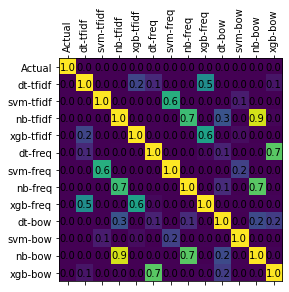

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
xgb-bow    0.453196  0.723837    0.588517  0.396721
svm-bow    0.229452  0.915698    0.572575  0.422951
xgb-tfidf  0.337900  0.790698    0.564299  0.556557
dt-bow     0.552511  0.566860    0.559686  0.465574
dt-tfidf   0.404110  0.712209    0.558159  0.587705
dt-freq    0.478311  0.636628    0.557469  0.522951
svm-freq   0.190639  0.921512    0.556075  0.581148
nb-bow     0.621005  0.479651    0.550328  0.386885
nb-tfidf   0.617580  0.482558    0.550069  0.579508
svm-tfidf  0.176941  0.921512    0.549226  0.529508
xgb-freq   0.389269  0.700581    0.544925  0.477049
nb-freq    0.647260  0.436047    0.541653  0.490984

Mean: 0.5917678543713906




Overall scores:
Friedman Chi Square Statistic: 33.142857142857146. p-value: 3.5254327078783125e-06.
           RandomUnder  SMOTETomek  RandomOver    ADASYN      none       aug
Actual        1.000000    1.000000    1.000000  1.000000  1.00000

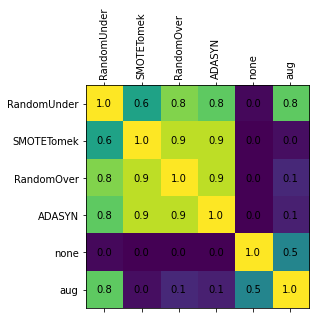

In [13]:
task_eval('strat-binary')


Task: 5Type


Method: RandomUnder

Task: 5type.
Cochran's Q test p-value: 1.467281451377e-311
Post-hoc Dunn test array:


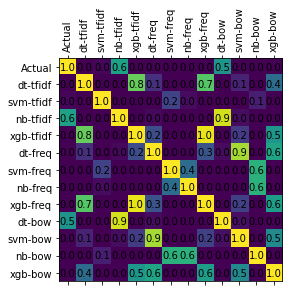

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
xgb-tfidf  0.457763  0.317647    0.250  0.380952  0.209677    0.323208   
xgb-bow    0.433790  0.329412    0.125  0.428571  0.233871    0.310129   
svm-bow    0.412100  0.347059    0.125  0.404762  0.233871    0.304558   
dt-tfidf   0.479452  0.252941    0.250  0.261905  0.241935    0.297247   
dt-freq    0.430365  0.300000    0.250  0.095238  0.298387    0.274798   
nb-bow     0.228311  0.382353    0.000  0.500000  0.169355    0.256004   
xgb-freq   0.474886  0.235294    0.125  0.142857  0.282258    0.252059   
nb-freq    0.219178  0.370588    0.000  0.452381  0.177419    0.243913   
nb-tfidf   0.361872  0.411765    0.125  0.095238  0.201613    0.239098   
dt-bow     0.381279  0.294118    0.000  0.333333  0.169355    0.235617   
svm-tfidf  0.312785  0.247059    0.000  0.285714  0.161290    0.201370   
svm-freq   0.292237  0.188235    0.000

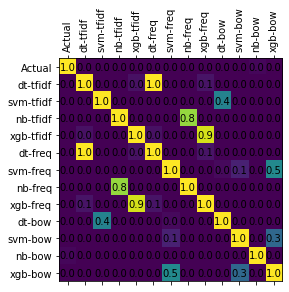

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
xgb-tfidf  0.748858  0.335294    0.000  0.166667  0.241935    0.298551   
svm-freq   0.535388  0.447059    0.000  0.333333  0.169355    0.297027   
svm-tfidf  0.448630  0.411765    0.000  0.404762  0.201613    0.293354   
xgb-freq   0.752283  0.347059    0.000  0.142857  0.193548    0.287149   
xgb-bow    0.557078  0.411765    0.000  0.214286  0.250000    0.286626   
dt-bow     0.469178  0.411765    0.000  0.238095  0.266129    0.277033   
svm-bow    0.592466  0.400000    0.000  0.142857  0.233871    0.273839   
nb-bow     0.302511  0.335294    0.125  0.357143  0.185484    0.261086   
nb-tfidf   0.140411  0.311765    0.250  0.380952  0.209677    0.258561   
dt-freq    0.715753  0.311765    0.000  0.119048  0.120968    0.253507   
dt-tfidf   0.722603  0.241176    0.000  0.119048  0.169355    0.250436   
nb-freq    0.142694  0.294118    0.250

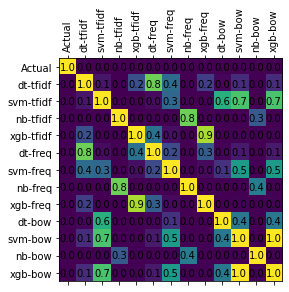

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
xgb-bow    0.632420  0.358824    0.375  0.309524  0.129032    0.360960   
svm-freq   0.626712  0.447059    0.000  0.452381  0.145161    0.334263   
svm-tfidf  0.608447  0.358824    0.000  0.523810  0.177419    0.333700   
dt-bow     0.609589  0.335294    0.250  0.238095  0.185484    0.323692   
svm-bow    0.635845  0.347059    0.250  0.214286  0.161290    0.321696   
nb-bow     0.075342  0.300000    0.375  0.547619  0.241935    0.307979   
xgb-freq   0.716895  0.323529    0.000  0.119048  0.241935    0.280281   
xgb-tfidf  0.713470  0.341176    0.000  0.095238  0.217742    0.273525   
dt-freq    0.704338  0.288235    0.000  0.119048  0.169355    0.256195   
nb-freq    0.117580  0.282353    0.250  0.452381  0.169355    0.254334   
dt-tfidf   0.692922  0.311765    0.000  0.095238  0.169355    0.253856   
nb-tfidf   0.118721  0.341176    0.250

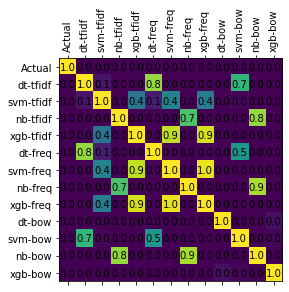

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
nb-bow     0.089041  0.311765    0.125  0.785714  0.266129    0.315530   
svm-tfidf  0.899543  0.158824    0.250  0.000000  0.048387    0.271351   
svm-freq   0.923516  0.182353    0.250  0.000000  0.000000    0.271174   
nb-tfidf   0.117580  0.347059    0.250  0.404762  0.177419    0.259364   
nb-freq    0.115297  0.294118    0.250  0.428571  0.185484    0.254694   
xgb-tfidf  0.900685  0.270588    0.000  0.000000  0.080645    0.250384   
xgb-freq   0.899543  0.270588    0.000  0.000000  0.072581    0.248542   
dt-tfidf   0.820776  0.241176    0.000  0.023810  0.104839    0.238120   
dt-freq    0.826484  0.258824    0.000  0.023810  0.080645    0.237952   
svm-bow    0.803653  0.335294    0.000  0.000000  0.016129    0.231015   
xgb-bow    0.735160  0.294118    0.000  0.095238  0.024194    0.229742   
dt-bow     0.676941  0.258824    0.000

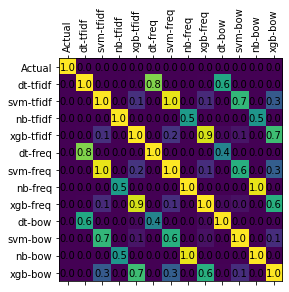

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
nb-bow     0.090183  0.305882    0.375  0.547619  0.241935    0.312124   
dt-bow     0.816210  0.388235    0.000  0.142857  0.064516    0.282364   
xgb-bow    0.898402  0.400000    0.000  0.047619  0.048387    0.278882   
svm-bow    0.942922  0.435294    0.000  0.000000  0.008065    0.277256   
svm-tfidf  0.948630  0.317647    0.000  0.000000  0.040323    0.261320   
xgb-tfidf  0.902968  0.305882    0.000  0.000000  0.080645    0.257899   
xgb-freq   0.900685  0.300000    0.000  0.000000  0.088710    0.257879   
nb-tfidf   0.118721  0.352941    0.250  0.404762  0.161290    0.257543   
dt-tfidf   0.821918  0.264706    0.000  0.023810  0.129032    0.247893   
nb-freq    0.115297  0.270588    0.250  0.428571  0.169355    0.246762   
svm-freq   0.962329  0.270588    0.000  0.000000  0.000000    0.246583   
dt-freq    0.818493  0.258824    0.000

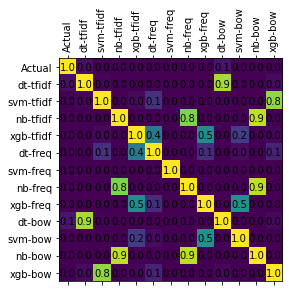

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
dt-freq    0.501142  0.382353    0.500  0.333333  0.290323    0.401430   
xgb-freq   0.542237  0.400000    0.375  0.380952  0.266129    0.392864   
xgb-tfidf  0.520548  0.394118    0.250  0.380952  0.298387    0.368801   
svm-tfidf  0.472603  0.317647    0.250  0.547619  0.233871    0.364348   
dt-tfidf   0.399543  0.305882    0.375  0.333333  0.362903    0.355332   
svm-bow    0.552511  0.411765    0.125  0.309524  0.346774    0.349115   
svm-freq   0.635845  0.394118    0.000  0.309524  0.346774    0.337252   
dt-bow     0.402968  0.300000    0.375  0.261905  0.338710    0.335716   
xgb-bow    0.456621  0.370588    0.125  0.309524  0.322581    0.316863   
nb-bow     0.250000  0.311765    0.250  0.428571  0.338710    0.315809   
nb-freq    0.252283  0.411765    0.125  0.380952  0.185484    0.271097   
nb-tfidf   0.265982  0.335294    0.000

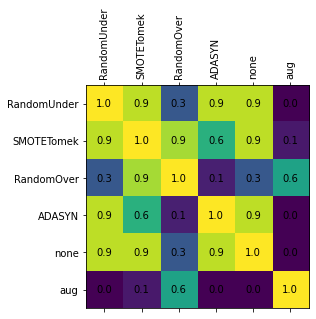

In [14]:
task_eval('5type')


Task: 4Type


Method: RandomUnder

Task: 4type.
Cochran's Q test p-value: 5.684879652185987e-309
Post-hoc Dunn test array:


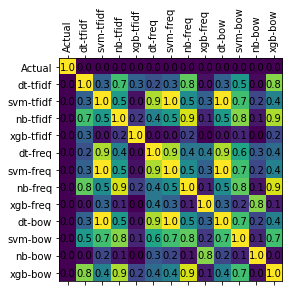

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
svm-freq   0.364706    0.625  0.435897  0.195122    0.405181  0.279412
xgb-freq   0.300000    0.625  0.410256  0.186992    0.380562  0.347059
xgb-tfidf  0.441176    0.250  0.461538  0.317073    0.367447  0.341176
dt-freq    0.347059    0.375  0.512821  0.195122    0.357500  0.317647
dt-tfidf   0.417647    0.250  0.333333  0.284553    0.321383  0.317647
svm-bow    0.417647    0.125  0.487179  0.178862    0.302172  0.344118
xgb-bow    0.441176    0.125  0.410256  0.211382    0.296954  0.394118
nb-bow     0.329412    0.250  0.435897  0.138211    0.288380  0.332353
svm-tfidf  0.323529    0.000  0.564103  0.252033    0.284916  0.270588
nb-tfidf   0.458824    0.125  0.333333  0.195122    0.278070  0.317647
nb-freq    0.476471    0.125  0.282051  0.195122    0.269661  0.355882
dt-bow     0.435294    0.000  0.282051  0.186992    0.226084  0.311765

Mean:

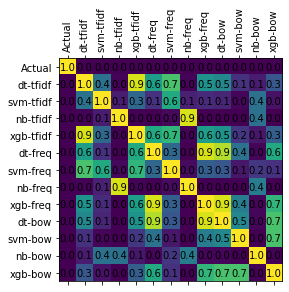

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
nb-bow     0.494118    0.500  0.589744  0.130081    0.428486  0.373529
svm-bow    0.600000    0.125  0.487179  0.398374    0.402638  0.444118
xgb-bow    0.570588    0.125  0.512821  0.390244    0.399663  0.429412
dt-bow     0.576471    0.125  0.564103  0.325203    0.397694  0.467647
svm-tfidf  0.476471    0.000  0.820513  0.211382    0.377091  0.488235
xgb-freq   0.582353    0.000  0.538462  0.325203    0.361504  0.447059
svm-freq   0.535294    0.000  0.666667  0.235772    0.359433  0.470588
dt-freq    0.594118    0.000  0.538462  0.300813    0.358348  0.408824
dt-tfidf   0.582353    0.000  0.461538  0.276423    0.330079  0.338235
nb-freq    0.517647    0.375  0.307692  0.105691    0.326508  0.473529
xgb-tfidf  0.558824    0.000  0.384615  0.341463    0.321226  0.341176
nb-tfidf   0.511765    0.375  0.282051  0.113821    0.320659  0.502941

Mean:

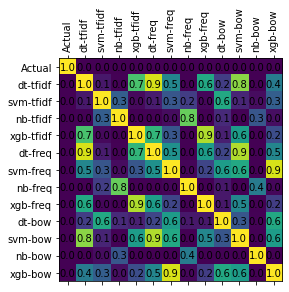

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
svm-freq   0.523529    0.125  0.769231  0.219512    0.409318  0.482353
svm-bow    0.588235    0.125  0.692308  0.211382    0.404231  0.461765
svm-tfidf  0.441176    0.125  0.820513  0.195122    0.395453  0.302941
dt-bow     0.547059    0.250  0.564103  0.178862    0.385006  0.458824
xgb-bow    0.547059    0.125  0.589744  0.235772    0.374394  0.432353
xgb-tfidf  0.552941    0.000  0.512821  0.390244    0.364001  0.476471
xgb-freq   0.576471    0.000  0.435897  0.398374    0.352686  0.388235
dt-freq    0.558824    0.000  0.461538  0.349593    0.342489  0.347059
dt-tfidf   0.541176    0.000  0.435897  0.390244    0.341829  0.335294
nb-bow     0.423529    0.500  0.282051  0.130081    0.333915  0.429412
nb-tfidf   0.517647    0.375  0.307692  0.121951    0.330573  0.452941
nb-freq    0.523529    0.375  0.282051  0.089431    0.317503  0.408824

Mean:

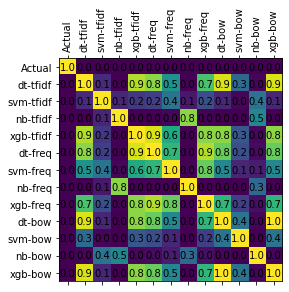

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
nb-bow     0.476471    0.500  0.794872  0.113821    0.471291  0.482353
xgb-bow    0.647059    0.125  0.256410  0.349593    0.344516  0.452941
dt-bow     0.670588    0.125  0.256410  0.317073    0.342268  0.417647
nb-tfidf   0.529412    0.375  0.307692  0.121951    0.333514  0.517647
nb-freq    0.529412    0.375  0.307692  0.097561    0.327416  0.382353
dt-tfidf   0.652941    0.000  0.307692  0.325203    0.321459  0.473529
svm-bow    0.735294    0.125  0.025641  0.398374    0.321077  0.479412
dt-freq    0.641176    0.000  0.256410  0.333333    0.307730  0.344118
xgb-tfidf  0.652941    0.000  0.230769  0.333333    0.304261  0.470588
xgb-freq   0.635294    0.000  0.205128  0.341463    0.295471  0.464706
svm-freq   0.664706    0.000  0.000000  0.333333    0.249510  0.352941
svm-tfidf  0.552941    0.000  0.000000  0.390244    0.235796  0.482353

Mean:

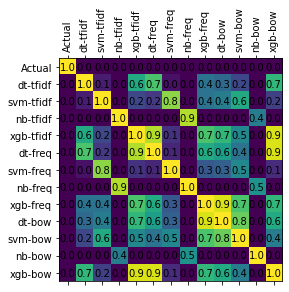

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
dt-bow     0.723529    0.125  0.384615  0.317073    0.387554  0.505882
nb-bow     0.458824    0.500  0.307692  0.105691    0.343052  0.502941
xgb-bow    0.664706    0.000  0.307692  0.373984    0.336595  0.523529
xgb-freq   0.711765    0.000  0.256410  0.373984    0.335540  0.500000
nb-tfidf   0.517647    0.375  0.307692  0.121951    0.330573  0.314706
nb-freq    0.523529    0.375  0.307692  0.097561    0.325946  0.535294
dt-freq    0.705882    0.000  0.256410  0.325203    0.321874  0.341176
xgb-tfidf  0.705882    0.000  0.205128  0.357724    0.317184  0.564706
dt-tfidf   0.664706    0.000  0.230769  0.349593    0.311267  0.520588
svm-freq   0.829412    0.000  0.000000  0.414634    0.311011  0.485294
svm-tfidf  0.800000    0.000  0.000000  0.430894    0.307724  0.555882
svm-bow    0.758824    0.000  0.025641  0.422764    0.301807  0.347059

Mean:

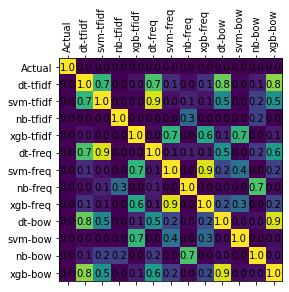

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
dt-tfidf   0.558824    0.500  0.564103  0.349593    0.493130  0.467647
dt-freq    0.458824    0.500  0.538462  0.455285    0.488142  0.494118
dt-bow     0.523529    0.500  0.435897  0.471545    0.482743  0.541176
xgb-tfidf  0.658824    0.250  0.487179  0.471545    0.466887  0.358824
xgb-freq   0.629412    0.250  0.435897  0.471545    0.446713  0.561765
svm-bow    0.682353    0.125  0.358974  0.536585    0.425728  0.464706
xgb-bow    0.547059    0.250  0.410256  0.455285    0.415650  0.397059
svm-freq   0.705882    0.000  0.538462  0.357724    0.400517  0.482353
nb-bow     0.376471    0.125  0.461538  0.463415    0.356606  0.491176
svm-tfidf  0.552941    0.000  0.512821  0.357724    0.355871  0.544118
nb-freq    0.423529    0.125  0.461538  0.357724    0.341948  0.579412
nb-tfidf   0.376471    0.000  0.358974  0.357724    0.273292  0.411765

Mean:

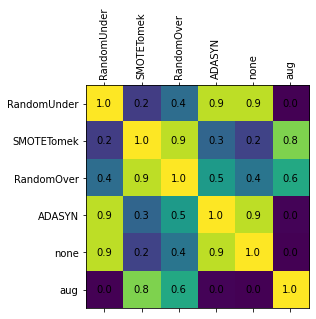

In [15]:
task_eval('4type')

In [16]:
def compare_aug(method):
    for task in ['binary', 'strat-binary', '5type', '4type']:
        df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
        aug_df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-aug.csv')
        df['Common'] = df.apply(lambda x: mode(np.array(x, dtype=np.int64)), axis=1)
        aug_df['Common'] = aug_df.apply(lambda x: mode(np.array(x, dtype=np.int64)), axis=1)
        result = cochrans_q([df['Common'], aug_df['Common']])
        
        #get row with int correct/incorrect
        aug_columns = list(aug_df.columns.values)
        common, actual = aug_columns.index('Common'), aug_columns.index('Actual')
        aug_df["Correct"] = aug_df.apply(lambda x: int(x[common] == x[actual]), axis=1)
        columns = list(df.columns.values)
        common, actual = columns.index('Common'), columns.index('Actual')
        df["Correct"] = df.apply(lambda x: int(x[common] == x[actual]), axis=1)
        
        print(f'Task: {task}')
        print(f"McNemar's test p-value: {result.pvalue}\n")
        print(f'Augmented mean accuracy: {aug_df["Correct"].mean()}.\nOriginal mean accuracy: {df["Correct"].mean()}.')
        print('\n')

In [17]:
compare_aug('RandomUnder')

Task: binary
McNemar's test p-value: 7.67181362310978e-27

Augmented mean accuracy: 0.7418032786885246.
Original mean accuracy: 0.7295081967213115.


Task: strat-binary
McNemar's test p-value: 1.4996716884060122e-14

Augmented mean accuracy: 0.48688524590163934.
Original mean accuracy: 0.40081967213114755.


Task: 5type
McNemar's test p-value: 1.622434810034379e-06

Augmented mean accuracy: 0.6024590163934426.
Original mean accuracy: 0.559016393442623.


Task: 4type
McNemar's test p-value: 0.03822250069159837

Augmented mean accuracy: 0.6147058823529412.
Original mean accuracy: 0.45.


